# Selective DA

In this version, we choose the variables carefully.

In [1]:
# Import library

import numpy as np
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from math import log

## Regression 1: Wellbeing against NDVI

### Well-being scores

In [2]:
# Read well-being
wellbeing = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'personal-well-being-borough.xlsx'),
                         sheet_name = 'Summary - Mean Scores', skiprows = 1)

# Rename and keep useful columns
wellbeing_cols = ['Life Satisfaction', 'Worthwhile', 'Happiness']
year = '2011/12'
wellbeing.rename({year: wellbeing_cols[0],
                 year+'.1': wellbeing_cols[1],
                 year+'.2': wellbeing_cols[2],
                 year+'.3': 'Anxiety'},
                axis = 1, inplace = True)
wellbeing = wellbeing[['Code', 'Area'] + wellbeing_cols + ['Anxiety']]

# Keep only data on London boroughs (Area Code starts with E09)
wellbeing.dropna(axis = 0, inplace = True)
wellbeing.drop(wellbeing[wellbeing.Area == "City of London"].index, inplace = True)
wellbeing = wellbeing[wellbeing['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
wellbeing = wellbeing.reset_index(drop = True)

# Set data type
wellbeing[wellbeing_cols + ['Anxiety']] = wellbeing[wellbeing_cols + ['Anxiety']].astype('float', copy = False)

### NDVI

In [3]:
# Read NDVI
ndvi_cols = ['lb_code', 'lb_name', 'percent_green']
ndvi = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'green_cover_borough_summary_0.05.xlsx'),
                         sheet_name = 'borough_green_cover', usecols = ndvi_cols)

# Drop City of London
ndvi.drop(ndvi[ndvi.lb_code == 'City of London'].index, inplace = True)
ndvi.sort_values(by = ['lb_name'], ascending=True)
ndvi = ndvi.reset_index(drop = True)

# Change name of 'City of Westminster' to Westminster
ndvi.loc[ndvi[ndvi.lb_code == 'City of Westminster'].index, 'lb_code'] = 'Westminster'

### Age and health

In [4]:
# Read self-reported health and age profile
age_cols = ['Age Structure (2011 Census);0-15;',
            'Age Structure (2011 Census);16-29;',
            'Age Structure (2011 Census);30-44;',
            'Age Structure (2011 Census);45-64;',
            'Age Structure (2011 Census);65+;']
health_cols = ['Health (2011 Census);Very good health;',
              'Health (2011 Census);Good health;',
              'Health (2011 Census);Fair health;',
              'Health (2011 Census);Bad health;',
              'Health (2011 Census);Very bad health;']
age_health = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'msoa-data.csv'),
                         usecols = ['Middle Super Output Area', 'MSOA Name',
                                    'Age Structure (2011 Census);All Ages;'] + age_cols + health_cols, 
                         low_memory = False, encoding = 'latin')

# Drop row on average for London and City of London
age_health.dropna(axis = 0, inplace = True)
age_health.drop(age_health[age_health['MSOA Name'] == 'City of London 001'].index, inplace = True)
age_health.reset_index(inplace = True)

# Change data type
age_health[age_cols] = age_health[age_cols].astype('int', copy = False)
age_health[health_cols] = age_health[health_cols].astype('int', copy = False)

# Drop numbers (last 4 characters) from MSOA name
for i in range(0, age_health.shape[0]):
               age_health.iloc[i,2] = age_health.iloc[i,2][:-4]

# Compute total number of respondents in MSOA
respondents = age_health.groupby('MSOA Name').agg({'Age Structure (2011 Census);All Ages;': np.sum}).reset_index()

# Compute number and percentage of respondents in each age group
age = age_health.groupby('MSOA Name').agg(dict.fromkeys(age_cols, np.sum)).reset_index()
age[age_cols] = age[age_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Compute number and percentage of respondents in each health category
health = age_health.groupby('MSOA Name').agg(dict.fromkeys(health_cols, np.sum)).reset_index()
health[health_cols] = health[health_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Rename columns for easy reference
age.rename({age_cols[0]: 'Age_0-15',
           age_cols[1]: 'Age_15-29',
           age_cols[2]: 'Age_30-44',
           age_cols[3]: 'Age_45-64',
           age_cols[4]: 'Age_65+'},
          axis = 1, inplace = True)
health.rename({health_cols[0]: 'Very_good',
               health_cols[1]: 'Good',
               health_cols[2]: 'Fair',
               health_cols[3]: 'Bad',
               health_cols[4]: 'Very_bad'},
              axis = 1, inplace = True)

### Multivariate regression - Wellbeing against NDVI and control variables (age, health)

In [5]:
# Merge data
data_uni = pd.merge(wellbeing[['Area'] + wellbeing_cols], ndvi[['lb_code','percent_green']], 
                    left_on = 'Area', right_on = 'lb_code').drop('lb_code', axis = 1)
data = data_uni.merge(health, left_on = 'Area', right_on = 'MSOA Name').drop('MSOA Name', axis = 1)
data = data.merge(age, left_on = 'Area', right_on = 'MSOA Name').drop('MSOA Name', axis = 1)

In [6]:
# Define function to drop variables using VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [7]:
# Drop collinear independent variables
data.drop(['Very_good', 'Age_65+'], axis = 1, inplace = True)
ind_var_data = drop_column_using_vif_(data.drop(['Area'] + wellbeing_cols, axis=1))

Dropping: Bad
Dropping: Age_45-64
Dropping: Fair


In [8]:
# Define function to extract outliers based on Tukey fences

def re_outliers(df, col_name):

    '''
    Remove the outliers from dataframe based on Tukey fences

    :param df: the pandas dataframe
    :param col_name: the column being checked for outliers
    :return: (1) dataframe with outliers removed, and (2) outliers [area] that have been removed
    '''

    # Initialize
    df_clean = df
    outliers_areas = []
    temp_areas = []

    while True:
    
        # Compute quartiles and IQR
        q1 = df_clean[col_name].quantile(0.25)
        q3 = df_clean[col_name].quantile(0.75)
        iqr = q3 - q1
        # Compute Tukey fences
        lo_tukey = q1 - 1.5*iqr
        hi_tukey = q3 + 1.5*iqr
    
        # Locate the rows and areas that are outside the Tukey fences
        outliers_rows = df_clean.index[(df_clean[col_name] < lo_tukey) | (df_clean[col_name] > hi_tukey)]
        
        if len(outliers_rows) > 0:
            temp_areas = df_clean['Area'][outliers_rows].values.tolist()
            outliers_areas = list(set(outliers_areas + temp_areas))
            df_clean = df_clean.drop(index = outliers_rows)
        else:
            break
    
    # Return both cleaned df and outlier areas
    return df_clean, sorted(outliers_areas)

In [9]:
# Define function to remove outliers in paired samples

def re_outliers_paired(df, col_name):

    '''
    Remove the outliers from dataframe based on Tukey fences in paired fashion for multiple columns

    :param df: the pandas dataframe
    :param col_name: the list of column(s) being checked for outliers
    :return: (1) dataframe with outliers removed, and (2) outliers [local authority area] that have been removed
    '''
    # initialize list to hold outlier areas
    outliers_area = []
    
    # For each column
    for col in col_name:
        # get outliers for the column
        temp_df, temp_outliers = re_outliers(df, col)
        # find all unique areas
        outliers_area = list(set(outliers_area + temp_outliers))
    
    outliers_area = sorted(outliers_area)
    
    # For all outlier areas
    df_clean = df
    for i in outliers_area:
        # Drop from df
        df_clean = df_clean.drop(df.index[df['Area'] == i])
    
    return df_clean, outliers_area

In [10]:
# Define function to perform backwards regression using p-value as selection criterion

def back_regress(df_dep, df_ind, thresh=0.05):
    '''
    Performs regression with backwards selection of variables using AIC as selection criterion.

    :param df_dep, df_ind: the pandas dataframe containing dependent variable and indepdendent variables respectively.
    :return: the final regression model
    '''    
    
    # Initialize index_to_drop
    index_to_drop = []
    
    while True:
        # Get variables
        var = df_ind.columns.values.tolist()
        
        # Perform regressions
        if index_to_drop == 'const':
            reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
        else:
            reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
        
        # Find p-values for all variables
        df_pval = reg_model.pvalues
        #df_pval = pd.Series([reg_model.pvalues[i] for i in var], name='pvalue', index = var).to_frame()
        
        # If best (lowest) new AIC is lower than the current best, remove variable that improves AIC the most
        if df_pval.max() > thresh:
            # If there are multiple variables with best new AIC, choose the first one
            index_to_drop = df_pval.index[df_pval == df_pval.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            # Drop variable from df_ind
            if index_to_drop != 'const':
                df_ind = df_ind.drop(columns = index_to_drop)
        else:
            break
            
    # Perform regression with final set of variables
    if index_to_drop == 'const':
        reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
    else:
        reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
    
    return reg_model

PERFORMING REGRESSION ON:LIFE SATISFACTION
Dropping: percent_green
Dropping: Age_15-29
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     16.42
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           6.23e-07
Time:                        22:39:04   Log-Likelihood:                 33.268
No. Observations:                  32   AIC:                            -56.54
Df Residuals:                      27   BIC:                            -49.21
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

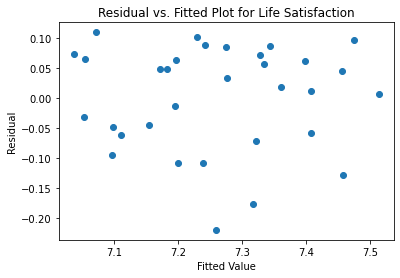



PERFORMING REGRESSION ON:WORTHWHILE
Dropping: percent_green
Dropping: Age_0-15
Dropping: Age_30-44
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     19.22
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           5.74e-07
Time:                        22:39:04   Log-Likelihood:                 29.928
No. Observations:                  32   AIC:                            -51.86
Df Residuals:                      28   BIC:                            -45.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

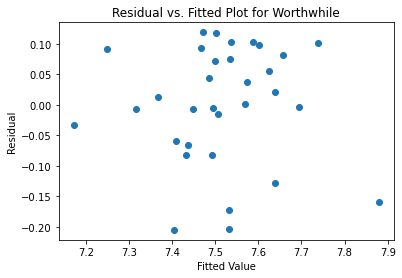



PERFORMING REGRESSION ON:HAPPINESS
Dropping: Age_15-29
Dropping: Good
Dropping: Age_30-44
Dropping: Very_bad
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     9.437
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           0.000697
Time:                        22:39:04   Log-Likelihood:                 26.587
No. Observations:                  32   AIC:                            -47.17
Df Residuals:                      29   BIC:                            -42.78
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------

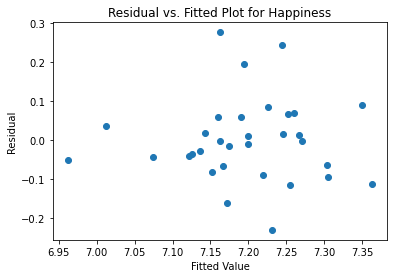

In [13]:
# Perform regression without removing outliers

for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Perform regression
    reg_model = back_regress(data[cat], ind_var_data)
    #reg_model = sm.OLS(endog=data[cat], exog=sm.add_constant(ind_var_data)).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: ['Barking and Dagenham', 'Camden', 'Enfield', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Newham', 'Redbridge', 'Wandsworth', 'Westminster']
Dropping: percent_green
Dropping: Age_15-29
Dropping: Age_0-15
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     11.96
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           0.000188
Time:                        22:37:37   Log-Likelihood:                 20.704
No. Observations:                  21   AIC:                            -33.41
Df Residuals:                      17   BIC:                            -29.23
Df Model:                           3                                         

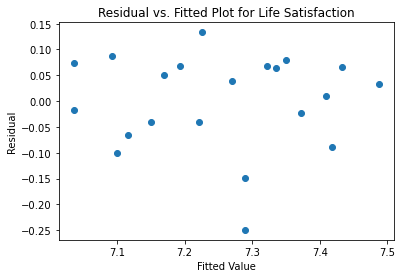



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: ['Barking and Dagenham', 'Camden', 'Enfield', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Newham', 'Redbridge', 'Wandsworth', 'Westminster']
Dropping: percent_green
Dropping: Age_0-15
Dropping: Age_15-29
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     12.56
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           0.000142
Time:                        22:37:37   Log-Likelihood:                 18.000
No. Observations:                  21   AIC:                            -28.00
Df Residuals:                      17   BIC:                            -23.82
Df Model:                           3                                         
Cova

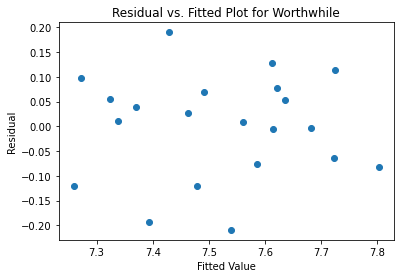



PERFORMING REGRESSION ON:HAPPINESS
Outliers: ['Barking and Dagenham', 'Camden', 'Enfield', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Newham', 'Redbridge', 'Wandsworth', 'Westminster']
Dropping: Age_0-15
Dropping: Good
Dropping: Very_bad
Dropping: Age_30-44
Dropping: Age_15-29
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     12.90
Date:                Thu, 06 Jan 2022   Prob (F-statistic):            0.00194
Time:                        22:37:38   Log-Likelihood:                 20.138
No. Observations:                  21   AIC:                            -36.28
Df Residuals:                      19   BIC:                            -34.19
Df Model:                           1                 

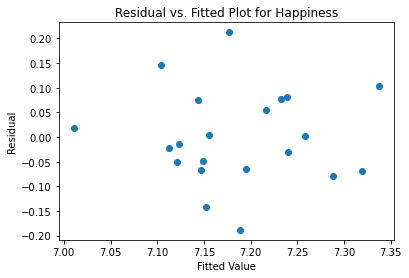

In [11]:
# Perform regression with outliers removed

for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    ind_var = ind_var_data.columns.tolist()
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    #reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

## Regression 2: Mediators against NDVI

### Physical activity

In [14]:
# Read in physical exercise (from 2012)
exercise = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'LSD21-APS-Physical-Activity-Levels.xlsx'),
                         sheet_name = '2012', usecols = ['GSS_Code', 'Region', 'Active'])

# Keep only data on London boroughs (Area Code starts with E09)
exercise = exercise[exercise['GSS_Code'].str.match(r'E09')].sort_values(by = ['GSS_Code'], ascending=True)
exercise = exercise.reset_index(drop = True)

# Convert 'Active' to percentage
exercise.Active = exercise.Active*100

                            OLS Regression Results                            
Dep. Variable:                 Active   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                 9.029e-05
Date:                Thu, 06 Jan 2022   Prob (F-statistic):              0.992
Time:                        22:40:52   Log-Likelihood:                -94.981
No. Observations:                  32   AIC:                             194.0
Df Residuals:                      30   BIC:                             196.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            56.6806      3.656     15.504

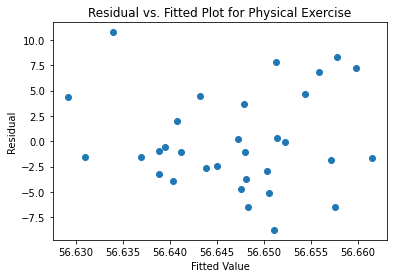

In [15]:
# Merge data
data_uni = pd.merge(exercise[['Region', 'Active']], ndvi[['lb_code','percent_green']], 
                    left_on = 'Region', right_on = 'lb_code').drop('lb_code', axis = 1)

# Regress physical activity against NDVI

reg_model = sm.OLS(endog=data_uni.Active, exog=sm.add_constant(data_uni.percent_green)).fit()
print(reg_model.summary())
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for Physical Exercise')
plt.show()

### Air Quality

In [16]:
# Read in air quality (from 2013)
air_quality = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'NO2_AnnualMean_2013_PopulationData.xlsx'),
                            sheet_name = 'Borough exceeding 40', skiprows = 4, 
                            usecols=['Borough Name', 'PopExc2013 %'])
air_quality['Borough Name'] = air_quality['Borough Name'].str.replace('&', 'and')

# Drop City of London
air_quality.drop(air_quality[air_quality['Borough Name'] == 'City of London'].index, inplace = True)
air_quality = air_quality.reset_index(drop = True)

In [17]:
# Log
air_quality['log_PopExc2013 %'] = air_quality['PopExc2013 %'].apply(log)

                            OLS Regression Results                            
Dep. Variable:       log_PopExc2013 %   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     17.60
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           0.000223
Time:                        22:41:50   Log-Likelihood:                -48.499
No. Observations:                  32   AIC:                             101.0
Df Residuals:                      30   BIC:                             103.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.5777      0.855      6.521

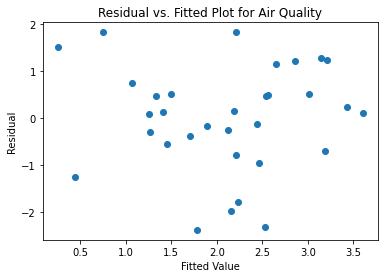

In [18]:
# Merge data
data_uni = pd.merge(air_quality, ndvi[['lb_code','percent_green']], 
                    left_on = 'Borough Name', right_on = 'lb_code').drop('lb_code', axis = 1)

# Regress air quality against NDVI without removing outliers

reg_model = sm.OLS(endog=data_uni['log_PopExc2013 %'], exog=sm.add_constant(data_uni.percent_green)).fit()
print(reg_model.summary())
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for Air Quality')
plt.show()

### Anxiety

                            OLS Regression Results                            
Dep. Variable:                Anxiety   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7343
Date:                Thu, 06 Jan 2022   Prob (F-statistic):              0.398
Time:                        22:42:20   Log-Likelihood:                -5.9201
No. Observations:                  32   AIC:                             15.84
Df Residuals:                      30   BIC:                             18.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.5964      0.226     15.907

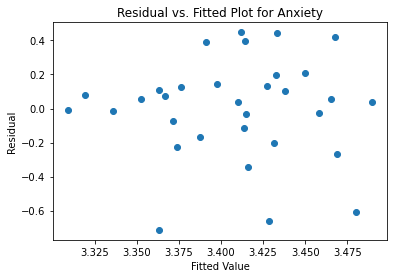

In [19]:
# Merge data
data_uni = pd.merge(wellbeing, ndvi[['lb_code','percent_green']], 
                    left_on = 'Area', right_on = 'lb_code').drop('lb_code', axis = 1)

# Regress physical activity against NDVI
reg_model = sm.OLS(endog=data_uni.Anxiety, exog=sm.add_constant(data_uni.percent_green)).fit()
print(reg_model.summary())
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for Anxiety')
plt.show()

## Regression 3: Wellbeing Against NDVI and Mediators

In [20]:
# Merge all variables into a dataframe
data = data.merge(air_quality[['Borough Name', 'log_PopExc2013 %']], 
                  left_on = 'Area', right_on = 'Borough Name').drop('Borough Name', axis = 1)

In [24]:
# Drop collinear independent variables
ind_var_data = drop_column_using_vif_(data.drop(['Area'] + wellbeing_cols, axis=1))

Dropping: Age_45-64
Dropping: Bad
Dropping: Fair


PERFORMING REGRESSION ON:LIFE SATISFACTION
Dropping: percent_green
Dropping: Age_15-29
Dropping: log_PopExc2013 %
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     16.42
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           6.23e-07
Time:                        22:45:24   Log-Likelihood:                 33.268
No. Observations:                  32   AIC:                            -56.54
Df Residuals:                      27   BIC:                            -49.21
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

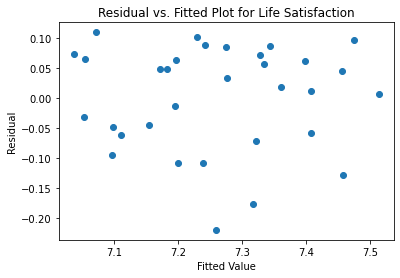



PERFORMING REGRESSION ON:WORTHWHILE
Dropping: percent_green
Dropping: Age_0-15
Dropping: log_PopExc2013 %
Dropping: Age_30-44
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     19.22
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           5.74e-07
Time:                        22:45:24   Log-Likelihood:                 29.928
No. Observations:                  32   AIC:                            -51.86
Df Residuals:                      28   BIC:                            -45.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

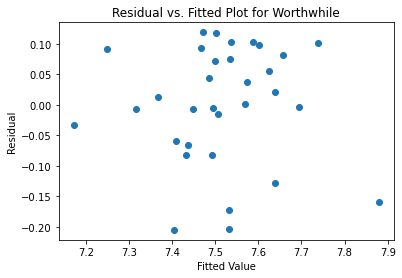



PERFORMING REGRESSION ON:HAPPINESS
Dropping: Good
Dropping: Age_15-29
Dropping: percent_green
Dropping: Age_0-15
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     11.10
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           5.64e-05
Time:                        22:45:25   Log-Likelihood:                 31.106
No. Observations:                  32   AIC:                            -54.21
Df Residuals:                      28   BIC:                            -48.35
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------

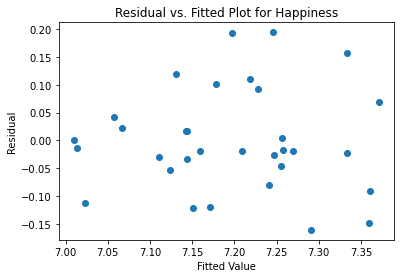

In [25]:
# Perform regression without removing outliers

for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Perform regression
    reg_model = back_regress(data[cat], ind_var_data)
    #reg_model = sm.OLS(endog=data[cat], exog=sm.add_constant(ind_var_data)).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: ['Barking and Dagenham', 'Camden', 'Enfield', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Newham', 'Redbridge', 'Wandsworth', 'Westminster']
Dropping: percent_green
Dropping: Good
Dropping: Very_bad
Dropping: Age_30-44
Dropping: log_PopExc2013 %
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     12.25
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           0.000438
Time:                        22:48:20   Log-Likelihood:                 17.812
No. Observations:                  21   AIC:                            -29.62
Df Residuals:                      18   BIC:                            -26.49
Df Model:                           

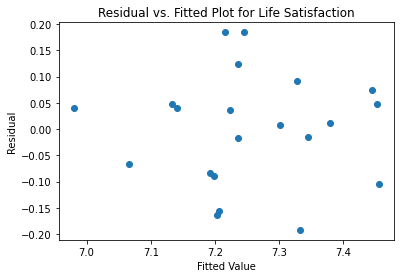



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: ['Barking and Dagenham', 'Camden', 'Enfield', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Newham', 'Redbridge', 'Wandsworth', 'Westminster']
Dropping: percent_green
Dropping: log_PopExc2013 %
Dropping: Age_0-15
Dropping: Age_15-29
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     12.56
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           0.000142
Time:                        22:48:20   Log-Likelihood:                 18.000
No. Observations:                  21   AIC:                            -28.00
Df Residuals:                      17   BIC:                            -23.82
Df Model:                           3                   

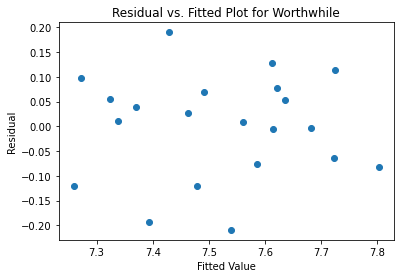



PERFORMING REGRESSION ON:HAPPINESS
Outliers: ['Barking and Dagenham', 'Camden', 'Enfield', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Newham', 'Redbridge', 'Wandsworth', 'Westminster']
Dropping: Age_15-29
Dropping: Very_bad
Dropping: Age_0-15
Dropping: Good
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     12.60
Date:                Thu, 06 Jan 2022   Prob (F-statistic):           0.000139
Time:                        22:48:20   Log-Likelihood:                 26.989
No. Observations:                  21   AIC:                            -45.98
Df Residuals:                      17   BIC:                            -41.80
Df Model:                           3                                     

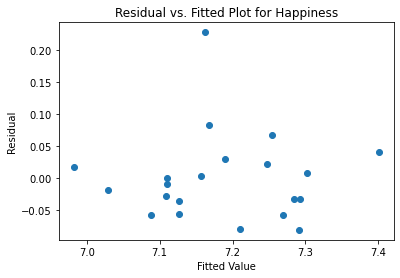

In [27]:
# Perform regression with outliers removed

for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    ind_var = ind_var_data.columns.tolist()
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    #reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')